In [2]:
# Exercice 5 : Visualisation du corpus
# M2 MIASHS : projet Network Analysis for Information Retrieval

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import os
import warnings
warnings.filterwarnings('ignore')

# Pour la visualisation
from wordcloud import WordCloud, STOPWORDS
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Pour l'interactivité dans Jupyter
from ipywidgets import interact, widgets, Layout, Button, HBox, VBox
from IPython.display import display, HTML, clear_output

# Pour le traitement de texte
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

# Pour LDA
import gensim
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# NLTK pour le prétraitement
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

# Téléchargement des ressources NLTK nécessaires
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Configuration pour un meilleur affichage
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Palette de couleurs personnalisée pour les visualisations
COLORS = plt.cm.tab20.colors + plt.cm.tab20b.colors

In [3]:
#===========================================================================================
# 1. Chargement et préparation des données
#===========================================================================================

def load_processed_data(file_path):
    """
    Charge les données traitées lors des exercices précédents.
    
    Args:
        file_path (str): Chemin du fichier pickle contenant le DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame contenant les articles
    """
    try:
        df = pd.read_pickle(file_path)
        print(f"Données chargées avec succès. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Erreur lors du chargement des données: {e}")
        return None

def prepare_texts(df):
    """
    Prépare les textes pour les visualisations.
    
    Args:
        df (pandas.DataFrame): DataFrame contenant les articles
        
    Returns:
        pandas.DataFrame: DataFrame avec texte combiné
    """
    df = df.copy()
    
    # Vérifier si la colonne 'combined_text' existe déjà
    if 'combined_text' not in df.columns:
        # Combiner le titre et le résumé
        df['combined_text'] = df.apply(
            lambda row: f"{row['title']} {row['abstract'] if pd.notna(row['abstract']) else ''}",
            axis=1
        )
    
    return df

#===========================================================================================
# 2. Visualisation des termes fréquents
#===========================================================================================

class TermVisualizer:
    """Classe pour visualiser les termes fréquents dans le corpus."""
    
    def __init__(self, df, text_column='combined_text'):
        """
        Initialise la classe avec le DataFrame d'articles.
        
        Args:
            df (pandas.DataFrame): DataFrame contenant les articles
            text_column (str): Nom de la colonne contenant le texte
        """
        self.df = df
        self.text_column = text_column
        self.texts = df[text_column].tolist()
        
        # Prétraitement
        self.stop_words = set(stopwords.words('english'))
        # Ajout de stop words spécifiques au domaine scientifique
        scientific_stop_words = [
            'doi', 'fig', 'figure', 'et', 'al', 'paper', 'study', 'research',
            'method', 'results', 'analysis', 'data', 'proposed', 'approach',
            'using', 'based', 'used', 'show', 'shown', 'table', 'section'
        ]
        self.stop_words.update(scientific_stop_words)
        
        # Stemming
        self.stemmer = PorterStemmer()
        
        # Résultats
        self.term_counts = None
        self.vectorizer = None
        
    def preprocess_text(self, text):
        """
        Prétraite un texte (minuscules, retrait ponctuation, etc.)
        
        Args:
            text (str): Texte à prétraiter
            
        Returns:
            str: Texte prétraité
        """
        # Conversion en minuscules
        text = text.lower()
        
        # Suppression des chiffres et de la ponctuation
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', ' ', text)
        
        # Suppression des espaces multiples
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def tokenize_and_stem(self, text):
        """
        Tokenise et applique le stemming au texte.
        
        Args:
            text (str): Texte à tokeniser
            
        Returns:
            list: Liste de stems
        """
        words = word_tokenize(text)
        return [self.stemmer.stem(word) for word in words if word.lower() not in self.stop_words]
    
    def extract_term_counts(self, min_df=5, max_df=0.95, max_features=None):
        """
        Extrait les comptes de termes pour le corpus.
        
        Args:
            min_df (int): Fréquence minimale des termes
            max_df (float): Fréquence maximale des termes
            max_features (int): Nombre maximum de features
            
        Returns:
            pandas.DataFrame: DataFrame contenant les comptes de termes
        """
        print("Extraction des comptes de termes...")
        
        # Création du vectoriseur
        self.vectorizer = CountVectorizer(
            preprocessor=self.preprocess_text,
            tokenizer=self.tokenize_and_stem,
            min_df=min_df,
            max_df=max_df,
            max_features=max_features
        )
        
        # Transformation des textes
        term_matrix = self.vectorizer.fit_transform(self.texts)
        
        # Conversion en DataFrame
        feature_names = self.vectorizer.get_feature_names_out()
        term_counts = np.array(term_matrix.sum(axis=0)).flatten()
        
        # Création du DataFrame
        self.term_counts = pd.DataFrame({
            'term': feature_names,
            'count': term_counts
        }).sort_values('count', ascending=False)
        
        print(f"Nombre de termes extraits: {len(self.term_counts)}")
        
        return self.term_counts
    
    def create_wordcloud(self, max_words=100, background_color='white', width=800, height=400, 
                        colormap='viridis', save_path=None):
        """
        Crée un nuage de mots à partir des comptes de termes.
        
        Args:
            max_words (int): Nombre maximum de mots dans le nuage
            background_color (str): Couleur de fond
            width (int): Largeur du nuage
            height (int): Hauteur du nuage
            colormap (str): Nom de la palette de couleurs
            save_path (str): Chemin pour enregistrer l'image
            
        Returns:
            WordCloud: Objet WordCloud généré
        """
        if self.term_counts is None:
            self.extract_term_counts()
        
        # Création du dictionnaire {mot: fréquence}
        word_freq = dict(zip(self.term_counts['term'], self.term_counts['count']))
        
        # Création du nuage de mots
        wordcloud = WordCloud(
            width=width,
            height=height,
            background_color=background_color,
            colormap=colormap,
            max_words=max_words,
            collocations=False,
            contour_width=1,
            contour_color='steelblue'
        ).generate_from_frequencies(word_freq)
        
        # Affichage
        plt.figure(figsize=(width/100, height/100))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Nuage de mots du corpus', fontsize=16)
        plt.tight_layout()
        
        # Sauvegarde si nécessaire
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
        
        plt.show()
        
        return wordcloud
    
    def plot_top_terms(self, n_terms=30, save_path=None):
        """
        Trace un graphique des termes les plus fréquents.
        
        Args:
            n_terms (int): Nombre de termes à afficher
            save_path (str): Chemin pour enregistrer l'image
            
        Returns:
            matplotlib.axes._axes.Axes: Objet axes de Matplotlib
        """
        if self.term_counts is None:
            self.extract_term_counts()
        
        # Sélection des n termes les plus fréquents
        top_terms = self.term_counts.head(n_terms)
        
        # Création du graphique
        plt.figure(figsize=(12, 10))
        ax = sns.barplot(x='count', y='term', data=top_terms, palette='viridis')
        plt.title(f'Top {n_terms} des termes les plus fréquents', fontsize=16)
        plt.xlabel('Fréquence', fontsize=12)
        plt.ylabel('Terme', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Ajout des valeurs sur les barres
        for i, v in enumerate(top_terms['count']):
            ax.text(v + 0.1, i, str(v), color='black', va='center')
        
        plt.tight_layout()
        
        # Sauvegarde si nécessaire
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
        
        plt.show()
        
        return ax
    
    def create_interactive_term_histogram(self, n_terms=50):
        """
        Crée un histogramme interactif des termes les plus fréquents.
        
        Args:
            n_terms (int): Nombre de termes à afficher
            
        Returns:
            plotly.graph_objects.Figure: Figure Plotly
        """
        if self.term_counts is None:
            self.extract_term_counts()
        
        # Sélection des n termes les plus fréquents
        top_terms = self.term_counts.head(n_terms)
        
        # Création de la figure Plotly
        fig = px.bar(
            top_terms,
            x='count',
            y='term',
            orientation='h',
            color='count',
            color_continuous_scale='viridis',
            title=f'Top {n_terms} des termes les plus fréquents',
            labels={'count': 'Fréquence', 'term': 'Terme'}
        )
        
        # Mise en forme
        fig.update_layout(
            height=800,
            width=1000,
            yaxis={'categoryorder': 'total ascending'},
            hovermode='closest',
            xaxis_title='Fréquence',
            yaxis_title='Terme',
            coloraxis_colorbar=dict(title='Fréquence'),
            font=dict(size=12)
        )
        
        return fig
    
    def create_term_cluster_heatmap(self, cluster_column, n_terms=30):
        """
        Crée une heatmap des termes les plus fréquents par cluster.
        
        Args:
            cluster_column (str): Nom de la colonne contenant les étiquettes de cluster
            n_terms (int): Nombre de termes à afficher
            
        Returns:
            matplotlib.figure.Figure: Figure Matplotlib
        """
        # Vérification de la présence de la colonne de cluster
        if cluster_column not in self.df.columns:
            print(f"Colonne de cluster '{cluster_column}' non trouvée.")
            return None
        
        # Nombre de clusters
        clusters = sorted(self.df[cluster_column].unique())
        if -1 in clusters:  # Exclure le bruit si présent
            clusters.remove(-1)
        
        # Préparation de la figure
        fig, axes = plt.subplots(len(clusters), 1, figsize=(10, 4 * len(clusters)))
        
        # Pour un seul cluster
        if len(clusters) == 1:
            axes = [axes]
        
        # Pour chaque cluster
        for i, cluster_id in enumerate(clusters):
            # Sélection des documents de ce cluster
            cluster_docs = self.df[self.df[cluster_column] == cluster_id][self.text_column].tolist()
            
            if not cluster_docs:
                continue
            
            # Vectorisation des documents de ce cluster
            cluster_vectorizer = CountVectorizer(
                preprocessor=self.preprocess_text,
                tokenizer=self.tokenize_and_stem,
                min_df=1
            )
            
            cluster_matrix = cluster_vectorizer.fit_transform(cluster_docs)
            
            # Comptes de termes pour ce cluster
            feature_names = cluster_vectorizer.get_feature_names_out()
            term_counts = np.array(cluster_matrix.sum(axis=0)).flatten()
            
            # Création du DataFrame
            cluster_term_counts = pd.DataFrame({
                'term': feature_names,
                'count': term_counts
            }).sort_values('count', ascending=False)
            
            # Sélection des n termes les plus fréquents
            top_terms = cluster_term_counts.head(n_terms)
            
            # Création du barplot
            sns.barplot(x='count', y='term', data=top_terms, palette='viridis', ax=axes[i])
            axes[i].set_title(f'Cluster {cluster_id}', fontsize=14)
            axes[i].set_xlabel('Fréquence')
            axes[i].set_ylabel('Terme')
            
            # Ajout des valeurs sur les barres
            for j, v in enumerate(top_terms['count']):
                axes[i].text(v + 0.1, j, str(v), color='black', va='center')
        
        plt.tight_layout()
        plt.show()
        
        return fig

#===========================================================================================
# 3. Visualisation des co-occurrences
#===========================================================================================

class CooccurrenceVisualizer:
    """Classe pour visualiser les co-occurrences de mots dans le corpus."""
    
    def __init__(self, df, text_column='combined_text'):
        """
        Initialise la classe avec le DataFrame d'articles.
        
        Args:
            df (pandas.DataFrame): DataFrame contenant les articles
            text_column (str): Nom de la colonne contenant le texte
        """
        self.df = df
        self.text_column = text_column
        self.texts = df[text_column].tolist()
        
        # Prétraitement
        self.stop_words = set(stopwords.words('english'))
        # Ajout de stop words spécifiques au domaine scientifique
        scientific_stop_words = [
            'doi', 'fig', 'figure', 'et', 'al', 'paper', 'study', 'research',
            'method', 'results', 'analysis', 'data', 'proposed', 'approach',
            'using', 'based', 'used', 'show', 'shown', 'table', 'section'
        ]
        self.stop_words.update(scientific_stop_words)
        
        # Stemming
        self.stemmer = PorterStemmer()
        
        # Résultats
        self.cooccurrence_matrix = None
        self.term_names = None
    
    def preprocess_text(self, text):
        """
        Prétraite un texte (minuscules, retrait ponctuation, etc.)
        
        Args:
            text (str): Texte à prétraiter
            
        Returns:
            str: Texte prétraité
        """
        # Conversion en minuscules
        text = text.lower()
        
        # Suppression des chiffres et de la ponctuation
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', ' ', text)
        
        # Suppression des espaces multiples
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def tokenize_and_stem(self, text):
        """
        Tokenise et applique le stemming au texte.
        
        Args:
            text (str): Texte à tokeniser
            
        Returns:
            list: Liste de stems
        """
        words = word_tokenize(text)
        return [self.stemmer.stem(word) for word in words if word.lower() not in self.stop_words]
    
    def build_cooccurrence_matrix(self, window_size=5, min_df=5, max_df=0.95, max_features=1000):
        """
        Construit une matrice de co-occurrences pour les termes du corpus.
        
        Args:
            window_size (int): Taille de la fenêtre pour les co-occurrences
            min_df (int): Fréquence minimale des termes
            max_df (float): Fréquence maximale des termes
            max_features (int): Nombre maximum de features
            
        Returns:
            numpy.ndarray: Matrice de co-occurrences
        """
        print("Construction de la matrice de co-occurrences...")
        
        # Prétraitement des textes
        processed_texts = [self.preprocess_text(text) for text in self.texts]
        
        # Tokenisation et stemming
        tokenized_texts = [self.tokenize_and_stem(text) for text in processed_texts]
        
        # Création du vocabulaire
        vectorizer = CountVectorizer(
            min_df=min_df,
            max_df=max_df,
            max_features=max_features,
            tokenizer=lambda x: x,  # Identité car les textes sont déjà tokenisés
            preprocessor=lambda x: x  # Identité car les textes sont déjà prétraités
        )
        
        # Ajustement du vectoriseur
        vectorizer.fit([' '.join(tokens) for tokens in tokenized_texts])
        
        # Récupération du vocabulaire
        vocabulary = vectorizer.vocabulary_
        self.term_names = vectorizer.get_feature_names_out()
        vocab_size = len(vocabulary)
        
        # Initialisation de la matrice de co-occurrences
        self.cooccurrence_matrix = np.zeros((vocab_size, vocab_size))
        
        # Construction de la matrice
        for tokens in tqdm(tokenized_texts, desc="Calcul des co-occurrences"):
            # Filtrer les tokens qui sont dans le vocabulaire
            filtered_tokens = [token for token in tokens if token in vocabulary]
            
            # Pour chaque fenêtre de taille window_size
            for i in range(len(filtered_tokens)):
                start = max(0, i - window_size)
                end = min(len(filtered_tokens), i + window_size + 1)
                
                # Token central
                token_i = filtered_tokens[i]
                token_i_idx = vocabulary[token_i]
                
                # Tokens dans la fenêtre
                for j in range(start, end):
                    if i != j:  # Exclure le token lui-même
                        token_j = filtered_tokens[j]
                        token_j_idx = vocabulary[token_j]
                        
                        # Incrémentation du compte de co-occurrences
                        self.cooccurrence_matrix[token_i_idx, token_j_idx] += 1
        
        print(f"Matrice de co-occurrences construite: {self.cooccurrence_matrix.shape}")
        
        return self.cooccurrence_matrix
    
    def extract_collocations(self, n_collocations=30):
        """
        Extrait les collocations (paires de mots significatives) du corpus.
        
        Args:
            n_collocations (int): Nombre de collocations à extraire
            
        Returns:
            list: Liste des collocations avec leurs scores
        """
        print("Extraction des collocations...")
        
        # Prétraitement des textes
        processed_texts = [self.preprocess_text(text) for text in self.texts]
        
        # Tokenisation
        tokenized_texts = []
        for text in processed_texts:
            words = word_tokenize(text)
            filtered_words = [word.lower() for word in words if word.lower() not in self.stop_words]
            tokenized_texts.append(filtered_words)
        
        # Concaténation de tous les tokens
        all_tokens = []
        for tokens in tokenized_texts:
            all_tokens.extend(tokens)
        
        # Création du finder de collocations
        finder = BigramCollocationFinder.from_words(all_tokens)
        
        # Filtrage des collocations rares
        finder.apply_freq_filter(5)
        
        # Calcul des collocations avec la méthode PMI
        bigram_measures = BigramAssocMeasures()
        collocations = finder.score_ngrams(bigram_measures.pmi)
        
        # Tri par score et sélection des n meilleures
        collocations = sorted(collocations, key=lambda x: x[1], reverse=True)[:n_collocations]
        
        print(f"Nombre de collocations extraites: {len(collocations)}")
        
        return collocations
    
    def plot_cooccurrence_network(self, n_edges=100, save_path=None):
        """
        Trace un réseau de co-occurrences.
        
        Args:
            n_edges (int): Nombre d'arêtes à afficher
            save_path (str): Chemin pour enregistrer l'image
            
        Returns:
            matplotlib.figure.Figure: Figure Matplotlib
        """
        if self.cooccurrence_matrix is None:
            self.build_cooccurrence_matrix()
        
        # Création du graphe
        G = nx.Graph()
        
        # Ajout des nœuds
        for i, term in enumerate(self.term_names):
            G.add_node(term)
        
        # Récupération des arêtes les plus importantes
        cooc_tuples = []
        
        # Pour chaque paire de termes
        for i in range(len(self.term_names)):
            for j in range(i+1, len(self.term_names)):
                weight = self.cooccurrence_matrix[i, j] + self.cooccurrence_matrix[j, i]
                if weight > 0:
                    cooc_tuples.append((self.term_names[i], self.term_names[j], weight))
        
        # Tri par poids
        cooc_tuples = sorted(cooc_tuples, key=lambda x: x[2], reverse=True)
        
        # Sélection des n arêtes les plus importantes
        for term1, term2, weight in cooc_tuples[:n_edges]:
            G.add_edge(term1, term2, weight=weight)
        
        # Calcul de la centralité des nœuds
        centrality = nx.degree_centrality(G)
        
        # Taille des nœuds en fonction de leur centralité
        node_size = [centrality[node] * 5000 for node in G.nodes()]
        
        # Création de la figure
        plt.figure(figsize=(20, 16))
        
        # Positions des nœuds
        pos = nx.spring_layout(G, seed=42)
        
        # Tracé des arêtes avec épaisseur proportionnelle au poids
        edges = G.edges(data=True)
        weights = [edge[2]['weight'] for edge in edges]
        max_weight = max(weights)
        norm_weights = [3 * weight / max_weight for weight in weights]
        
        nx.draw_networkx_edges(
            G, 
            pos, 
            width=norm_weights, 
            alpha=0.7,
            edge_color='lightgray'
        )
        
        # Tracé des nœuds
        nx.draw_networkx_nodes(
            G, 
            pos, 
            node_size=node_size, 
            node_color=list(centrality.values()),
            cmap=plt.cm.viridis,
            alpha=0.8
        )
        
        # Tracé des labels
        nx.draw_networkx_labels(
            G, 
            pos, 
            font_size=10, 
            font_family='sans-serif'
        )
        
        plt.axis('off')
        plt.title('Réseau de co-occurrences de termes', fontsize=20)
        
        # Sauvegarde si nécessaire
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
        
        plt.show()
        
        return plt.gcf()
    
    def plot_collocations(self, n_collocations=30, save_path=None):
        """
        Trace un graphique des collocations les plus significatives.
        
        Args:
            n_collocations (int): Nombre de collocations à afficher
            save_path (str): Chemin pour enregistrer l'image
            
        Returns:
            matplotlib.axes._axes.Axes: Objet axes de Matplotlib
        """
        # Extraction des collocations
        collocations = self.extract_collocations(n_collocations)
        
        # Création du DataFrame
        df_collocations = pd.DataFrame([
            {'collocation': ' + '.join(colloc[0]), 'score': colloc[1]}
            for colloc in collocations
        ])
        
        # Création du graphique
        plt.figure(figsize=(12, 10))
        ax = sns.barplot(x='score', y='collocation', data=df_collocations, palette='viridis')
        plt.title(f'Top {n_collocations} des collocations les plus significatives', fontsize=16)
        plt.xlabel('Score PMI', fontsize=12)
        plt.ylabel('Collocation', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Ajout des valeurs sur les barres
        for i, v in enumerate(df_collocations['score']):
            ax.text(v + 0.01, i, f"{v:.2f}", color='black', va='center')
        
        plt.tight_layout()
        
        # Sauvegarde si nécessaire
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
        
        plt.show()
        
        return ax
    
    def create_interactive_cooccurrence_network(self, n_nodes=50, n_edges=100):
        """
        Crée un réseau interactif de co-occurrences avec Plotly.
        
        Args:
            n_nodes (int): Nombre de nœuds à afficher
            n_edges (int): Nombre d'arêtes à afficher
            
        Returns:
            plotly.graph_objects.Figure: Figure Plotly
        """
        if self.cooccurrence_matrix is None:
            self.build_cooccurrence_matrix()
        
        # Création du graphe
        G = nx.Graph()
        
        # Calcul de la somme des co-occurrences pour chaque terme
        term_importance = np.sum(self.cooccurrence_matrix, axis=1)
        
        # Sélection des n_nodes termes les plus importants
        top_indices = np.argsort(term_importance)[-n_nodes:]
        top_terms = [self.term_names[i] for i in top_indices]
        
        # Ajout des nœuds
        for term in top_terms:
            G.add_node(term)
        
        # Récupération des arêtes les plus importantes
        cooc_tuples = []
        
        # Pour chaque paire de termes parmi les top_terms
        for i, term1 in enumerate(top_terms):
            idx1 = np.where(self.term_names == term1)[0][0]
            for j, term2 in enumerate(top_terms[i+1:], i+1):
                idx2 = np.where(self.term_names == term2)[0][0]
                weight = self.cooccurrence_matrix[idx1, idx2] + self.cooccurrence_matrix[idx2, idx1]
                if weight > 0:
                    cooc_tuples.append((term1, term2, weight))
        
        # Tri par poids
        cooc_tuples = sorted(cooc_tuples, key=lambda x: x[2], reverse=True)
        
        # Sélection des n arêtes les plus importantes
        for term1, term2, weight in cooc_tuples[:n_edges]:
            G.add_edge(term1, term2, weight=weight)
        
        # Calcul de la centralité des nœuds
        centrality = nx.degree_centrality(G)
        
        # Positions des nœuds
        pos = nx.spring_layout(G, seed=42)
        
        # Préparation des données pour Plotly
        edge_x = []
        edge_y = []
        edge_colors = []
        edge_weights = []
        
        for edge in G.edges(data=True):
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
            edge_colors.append(edge[2]['weight'])
            edge_weights.append(edge[2]['weight'])
        
        # Normalisation des poids pour les couleurs
        max_weight = max(edge_weights) if edge_weights else 1
        edge_colors = [w / max_weight for w in edge_colors]
        
        # Tracé des arêtes
        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=1, color='lightgray'),
            hoverinfo='none',
            mode='lines'
        )
        
        # Tracé des nœuds
        node_x = []
        node_y = []
        node_text = []
        node_size = []
        node_color = []
        
        for node in G.nodes():
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
            node_text.append(node)
            node_size.append(centrality[node] * 50)
            node_color.append(centrality[node])
        
        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers+text',
            text=node_text,
            textposition='top center',
            marker=dict(
                showscale=True,
                colorscale='Viridis',
                size=node_size,
                color=node_color,
                colorbar=dict(
                    thickness=15,
                    title='Centralité',
                    xanchor='left',
                    titleside='right'
                ),
                line_width=2
            ),
            hoverinfo='text'
        )
        
        # Création de la figure
        fig = go.Figure(data=[edge_trace, node_trace],
                        layout=go.Layout(
                            title='Réseau de co-occurrences de termes (interactif)',
                            showlegend=False,
                            hovermode='closest',
                            margin=dict(b=20, l=5, r=5, t=40),
                            annotations=[dict(
                                text="Réseau de co-occurrences",
                                showarrow=False,
                                xref="paper", yref="paper",
                                x=0.005, y=-0.002)],
                            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                            width=1000,
                            height=800,
                        )
                        )
        
        return fig

#===========================================================================================
# 4. Visualisation des thématiques LDA
#===========================================================================================

class LDAVisualizer:
    """Classe pour visualiser les thématiques LDA dans le corpus."""
    
    def __init__(self, df, text_column='combined_text'):
        """
        Initialise la classe avec le DataFrame d'articles.
        
        Args:
            df (pandas.DataFrame): DataFrame contenant les articles
            text_column (str): Nom de la colonne contenant le texte
        """
        self.df = df
        self.text_column = text_column
        self.texts = df[text_column].tolist()
        
        # Prétraitement
        self.stop_words = set(stopwords.words('english'))
        # Ajout de stop words spécifiques au domaine scientifique
        scientific_stop_words = [
            'doi', 'fig', 'figure', 'et', 'al', 'paper', 'study', 'research',
            'method', 'results', 'analysis', 'data', 'proposed', 'approach',
            'using', 'based', 'used', 'show', 'shown', 'table', 'section'
        ]
        self.stop_words.update(scientific_stop_words)
        
        # Stemming
        self.stemmer = PorterStemmer()
        
        # Résultats
        self.lda_model = None
        self.corpus = None
        self.dictionary = None
        self.doc_topic_matrix = None
    
    def preprocess_text(self, text):
        """
        Prétraite un texte (minuscules, retrait ponctuation, etc.)
        
        Args:
            text (str): Texte à prétraiter
            
        Returns:
            str: Texte prétraité
        """
        # Conversion en minuscules
        text = text.lower()
        
        # Suppression des chiffres et de la ponctuation
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', ' ', text)
        
        # Suppression des espaces multiples
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def tokenize_and_stem(self, text):
        """
        Tokenise et applique le stemming au texte.
        
        Args:
            text (str): Texte à tokeniser
            
        Returns:
            list: Liste de stems
        """
        words = word_tokenize(text)
        return [self.stemmer.stem(word) for word in words if word.lower() not in self.stop_words]
    
    def fit_lda_model(self, num_topics=10, chunksize=2000, passes=20, min_df=5, max_df=0.95):
        """
        Entraîne un modèle LDA sur le corpus.
        
        Args:
            num_topics (int): Nombre de thématiques à extraire
            chunksize (int): Taille des batchs pour l'entraînement
            passes (int): Nombre de passes d'entraînement
            min_df (int): Fréquence minimale des termes
            max_df (float): Fréquence maximale des termes
            
        Returns:
            gensim.models.LdaModel: Modèle LDA entraîné
        """
        print("Entraînement du modèle LDA...")
        
        # Prétraitement des textes
        processed_texts = []
        for text in tqdm(self.texts, desc="Prétraitement des textes"):
            text = self.preprocess_text(text)
            words = word_tokenize(text)
            processed_texts.append([word for word in words if word.lower() not in self.stop_words])
        
        # Création du dictionnaire
        self.dictionary = Dictionary(processed_texts)
        
        # Filtrage des mots rares et fréquents
        if min_df > 1:
            self.dictionary.filter_extremes(no_below=min_df)
        if max_df < 1:
            self.dictionary.filter_extremes(no_above=max_df)
        
        # Création du corpus
        self.corpus = [self.dictionary.doc2bow(text) for text in processed_texts]
        
        # Entraînement du modèle LDA
        self.lda_model = LdaModel(
            corpus=self.corpus,
            id2word=self.dictionary,
            num_topics=num_topics,
            alpha='auto',
            eta='auto',
            chunksize=chunksize,
            passes=passes
        )
        
        # Création de la matrice document-thématique
        self.doc_topic_matrix = np.zeros((len(self.texts), num_topics))
        for i, doc_bow in enumerate(self.corpus):
            topic_probs = dict(self.lda_model.get_document_topics(doc_bow, minimum_probability=0))
            for topic_idx, prob in topic_probs.items():
                self.doc_topic_matrix[i, topic_idx] = prob
        
        print(f"Modèle LDA entraîné avec {num_topics} thématiques")
        
        return self.lda_model
    
    def print_topics(self, num_words=10):
        """
        Affiche les thématiques extraites par le modèle LDA.
        
        Args:
            num_words (int): Nombre de mots à afficher par thématique
        """
        if self.lda_model is None:
            print("Le modèle LDA n'a pas été entraîné.")
            return
        
        print(f"Thématiques extraites par le modèle LDA ({num_words} mots par thématique):")
        
        for idx, topic in self.lda_model.show_topics(formatted=False, num_topics=-1, num_words=num_words):
            print(f"\nThématique #{idx}:")
            print(', '.join([f"{word} ({prob:.4f})" for word, prob in topic]))
    
    def visualize_lda_with_pyldavis(self, save_path=None):
        """
        Visualise les thématiques LDA avec pyLDAvis.
        
        Args:
            save_path (str): Chemin pour enregistrer la visualisation HTML
            
        Returns:
            pyLDAvis.PreparedData: Objet PreparedData de pyLDAvis
        """
        if self.lda_model is None:
            print("Le modèle LDA n'a pas été entraîné.")
            return
        
        # Préparation de la visualisation
        prepared_data = gensimvis.prepare(
            self.lda_model, 
            self.corpus, 
            self.dictionary,
            sort_topics=False
        )
        
        # Sauvegarde si nécessaire
        if save_path:
            pyLDAvis.save_html(prepared_data, save_path)
            print(f"Visualisation LDA sauvegardée dans {save_path}")
        
        # Affichage
        return pyLDAvis.display(prepared_data)
    
    def plot_topic_distribution(self, save_path=None):
        """
        Trace la distribution des thématiques dans le corpus.
        
        Args:
            save_path (str): Chemin pour enregistrer l'image
            
        Returns:
            matplotlib.figure.Figure: Figure Matplotlib
        """
        if self.doc_topic_matrix is None:
            print("Le modèle LDA n'a pas été entraîné.")
            return
        
        # Calcul de la proportion de chaque thématique
        topic_proportions = self.doc_topic_matrix.mean(axis=0)
        
        # Création du DataFrame
        df_topics = pd.DataFrame({
            'topic': [f"Thématique #{i}" for i in range(len(topic_proportions))],
            'proportion': topic_proportions
        })
        
        # Tri par proportion
        df_topics = df_topics.sort_values('proportion', ascending=False)
        
        # Création du graphique
        plt.figure(figsize=(12, 8))
        ax = sns.barplot(x='proportion', y='topic', data=df_topics, palette='viridis')
        plt.title('Distribution des thématiques dans le corpus', fontsize=16)
        plt.xlabel('Proportion', fontsize=12)
        plt.ylabel('Thématique', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Ajout des valeurs sur les barres
        for i, v in enumerate(df_topics['proportion']):
            ax.text(v + 0.001, i, f"{v:.4f}", color='black', va='center')
        
        plt.tight_layout()
        
        # Sauvegarde si nécessaire
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
        
        plt.show()
        
        return plt.gcf()
    
    def plot_document_topic_heatmap(self, n_docs=50, save_path=None):
        """
        Trace une heatmap des thématiques pour un échantillon de documents.
        
        Args:
            n_docs (int): Nombre de documents à afficher
            save_path (str): Chemin pour enregistrer l'image
            
        Returns:
            matplotlib.figure.Figure: Figure Matplotlib
        """
        if self.doc_topic_matrix is None:
            print("Le modèle LDA n'a pas été entraîné.")
            return
        
        # Échantillonnage aléatoire des documents
        np.random.seed(42)
        sample_indices = np.random.choice(len(self.texts), min(n_docs, len(self.texts)), replace=False)
        
        # Sous-ensemble de la matrice document-thématique
        sample_matrix = self.doc_topic_matrix[sample_indices]
        
        # Titres des documents échantillonnés
        sample_titles = self.df.iloc[sample_indices]['title'].tolist()
        
        # Création de la heatmap
        plt.figure(figsize=(14, 10))
        ax = sns.heatmap(
            sample_matrix,
            cmap='viridis',
            xticklabels=[f"T{i}" for i in range(sample_matrix.shape[1])],
            yticklabels=[title[:30] + '...' if len(title) > 30 else title for title in sample_titles],
            cbar_kws={'label': 'Proportion'}
        )
        plt.title('Distribution des thématiques par document', fontsize=16)
        plt.xlabel('Thématiques', fontsize=12)
        plt.ylabel('Documents', fontsize=12)
        plt.tight_layout()
        
        # Sauvegarde si nécessaire
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
        
        plt.show()
        
        return plt.gcf()
    
    def create_topic_wordclouds(self, save_dir=None):
        """
        Crée un nuage de mots pour chaque thématique.
        
        Args:
            save_dir (str): Répertoire pour enregistrer les images
            
        Returns:
            dict: Dictionnaire des nuages de mots par thématique
        """
        if self.lda_model is None:
            print("Le modèle LDA n'a pas été entraîné.")
            return
        
        # Création du répertoire si nécessaire
        if save_dir and not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        # Récupération des thématiques
        topics = self.lda_model.show_topics(formatted=False, num_topics=-1, num_words=50)
        
        # Création des nuages de mots
        wordclouds = {}
        
        for topic_id, topic in topics:
            # Création du dictionnaire {mot: poids}
            word_dict = {word: prob for word, prob in topic}
            
            # Création du nuage de mots
            wordcloud = WordCloud(
                width=800,
                height=400,
                background_color='white',
                colormap='viridis',
                max_words=100,
                collocations=False,
                contour_width=1,
                contour_color='steelblue'
            ).generate_from_frequencies(word_dict)
            
            # Stockage du nuage de mots
            wordclouds[topic_id] = wordcloud
            
            # Affichage
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Thématique #{topic_id}', fontsize=16)
            plt.tight_layout()
            
            # Sauvegarde si nécessaire
            if save_dir:
                plt.savefig(os.path.join(save_dir, f'topic_{topic_id}.png'), bbox_inches='tight', dpi=300)
            
            plt.show()
        
        return wordclouds
    
    def visualize_doc_topic_tsne(self, title_column='title', save_path=None):
        """
        Visualise les documents dans l'espace des thématiques via t-SNE.
        
        Args:
            title_column (str): Nom de la colonne contenant les titres des documents
            save_path (str): Chemin pour enregistrer l'image
            
        Returns:
            matplotlib.figure.Figure: Figure Matplotlib
        """
        if self.doc_topic_matrix is None:
            print("Le modèle LDA n'a pas été entraîné.")
            return
        
        # Réduction de dimensionnalité avec t-SNE
        tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
        topic_tsne = tsne.fit_transform(self.doc_topic_matrix)
        
        # Récupération du topic dominant pour chaque document
        dominant_topics = np.argmax(self.doc_topic_matrix, axis=1)
        
        # Création de la figure
        plt.figure(figsize=(12, 10))
        
        # Palette de couleurs pour les topics
        num_topics = self.doc_topic_matrix.shape[1]
        colors = plt.cm.tab20(np.linspace(0, 1, num_topics))
        
        # Tracé des points
        for topic_idx in range(num_topics):
            # Indices des documents de ce topic
            indices = np.where(dominant_topics == topic_idx)[0]
            
            # Tracé des points
            plt.scatter(
                topic_tsne[indices, 0],
                topic_tsne[indices, 1],
                c=[colors[topic_idx]],
                label=f'Topic {topic_idx}',
                alpha=0.7,
                s=30
            )
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title('Visualisation t-SNE des documents par thématique dominante', fontsize=16)
        plt.xlabel('t-SNE dimension 1')
        plt.ylabel('t-SNE dimension 2')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Sauvegarde si nécessaire
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
        
        plt.show()
        
        return plt.gcf()

#===========================================================================================
# 5. Visualisation interactive pour l'exploration
#===========================================================================================

class InteractiveExplorer:
    """Classe pour l'exploration interactive du corpus."""
    
    def __init__(self, df, text_column='combined_text', cluster_column=None, lda_model=None, doc_topic_matrix=None):
        """
        Initialise la classe avec le DataFrame d'articles.
        
        Args:
            df (pandas.DataFrame): DataFrame contenant les articles
            text_column (str): Nom de la colonne contenant le texte
            cluster_column (str): Nom de la colonne contenant les étiquettes de cluster
            lda_model: Modèle LDA
            doc_topic_matrix: Matrice document-thématique
        """
        self.df = df
        self.text_column = text_column
        self.cluster_column = cluster_column
        self.lda_model = lda_model
        self.doc_topic_matrix = doc_topic_matrix
        
        # Prétraitement
        self.vectorizer = TfidfVectorizer(
            min_df=5, 
            max_df=0.95,
            stop_words='english'
        )
        
        # Vectorisation du corpus
        self.tfidf_matrix = self.vectorizer.fit_transform(df[text_column])
        self.feature_names = self.vectorizer.get_feature_names_out()
    
    def search_term(self, term, threshold=0.0, max_results=20):
        """
        Recherche les documents contenant un terme donné.
        
        Args:
            term (str): Terme à rechercher
            threshold (float): Seuil de similarité minimal
            max_results (int): Nombre maximum de résultats
            
        Returns:
            pandas.DataFrame: DataFrame contenant les résultats de la recherche
        """
        # Vérification si le terme est dans le vocabulaire
        if term not in self.vectorizer.vocabulary_:
            return pd.DataFrame({'message': [f"Terme '{term}' non trouvé dans le vocabulaire."]})
        
        # Récupération de l'indice du terme
        term_idx = self.vectorizer.vocabulary_[term]
        
        # Récupération des scores TF-IDF pour ce terme dans tous les documents
        term_scores = self.tfidf_matrix[:, term_idx].toarray().flatten()
        
        # Filtrage des documents avec un score supérieur au seuil
        results_idx = np.where(term_scores > threshold)[0]
        
        # Tri par score
        sorted_idx = results_idx[np.argsort(term_scores[results_idx])[::-1]]
        
        # Limitation du nombre de résultats
        sorted_idx = sorted_idx[:max_results]
        
        # Création du DataFrame de résultats
        results = []
        
        for idx in sorted_idx:
            doc = self.df.iloc[idx]
            result = {
                'id': idx,
                'title': doc['title'],
                'score': term_scores[idx],
                'abstract': doc.get('abstract', '')
            }
            
            # Ajout du cluster si disponible
            if self.cluster_column and self.cluster_column in self.df.columns:
                result['cluster'] = doc[self.cluster_column]
            
            # Ajout des thématiques LDA si disponibles
            if self.doc_topic_matrix is not None:
                top_topic_idx = np.argmax(self.doc_topic_matrix[idx])
                result['dominant_topic'] = top_topic_idx
                result['topic_score'] = self.doc_topic_matrix[idx, top_topic_idx]
            
            results.append(result)
        
        return pd.DataFrame(results)
    
    def find_co_occurring_terms(self, term, n_terms=20):
        """
        Trouve les termes qui co-occurrent avec un terme donné.
        
        Args:
            term (str): Terme à analyser
            n_terms (int): Nombre de termes à retourner
            
        Returns:
            pandas.DataFrame: DataFrame contenant les termes co-occurrents
        """
        # Vérification si le terme est dans le vocabulaire
        if term not in self.vectorizer.vocabulary_:
            return pd.DataFrame({'message': [f"Terme '{term}' non trouvé dans le vocabulaire."]})
        
        # Récupération de l'indice du terme
        term_idx = self.vectorizer.vocabulary_[term]
        
        # Récupération des documents contenant ce terme
        term_docs = self.tfidf_matrix[:, term_idx].nonzero()[0]
        
        if len(term_docs) == 0:
            return pd.DataFrame({'message': [f"Aucun document contenant '{term}' trouvé."]})
        
        # Somme des scores TF-IDF pour tous les termes dans ces documents
        term_sums = np.array(self.tfidf_matrix[term_docs].sum(axis=0)).flatten()
        
        # Mise à zéro du score du terme lui-même
        term_sums[term_idx] = 0
        
        # Récupération des indices des termes les plus co-occurrents
        co_indices = term_sums.argsort()[::-1][:n_terms]
        
        # Création du DataFrame de résultats
        co_terms = []
        
        for idx in co_indices:
            co_term = self.feature_names[idx]
            co_terms.append({
                'term': co_term,
                'score': term_sums[idx]
            })
        
        return pd.DataFrame(co_terms)
    
    def plot_term_cluster_distribution(self, term):
        """
        Trace la distribution d'un terme par cluster.
        
        Args:
            term (str): Terme à analyser
            
        Returns:
            matplotlib.figure.Figure: Figure Matplotlib
        """
        # Vérification si le terme est dans le vocabulaire
        if term not in self.vectorizer.vocabulary_:
            print(f"Terme '{term}' non trouvé dans le vocabulaire.")
            return None
        
        # Vérification si la colonne de cluster est disponible
        if self.cluster_column is None or self.cluster_column not in self.df.columns:
            print("Colonne de cluster non disponible.")
            return None
        
        # Récupération de l'indice du terme
        term_idx = self.vectorizer.vocabulary_[term]
        
        # Récupération des scores TF-IDF pour ce terme dans tous les documents
        term_scores = self.tfidf_matrix[:, term_idx].toarray().flatten()
        
        # Ajout des scores au DataFrame
        df_temp = self.df.copy()
        df_temp['term_score'] = term_scores
        
        # Calcul de la moyenne des scores par cluster
        cluster_scores = df_temp.groupby(self.cluster_column)['term_score'].mean().reset_index()
        cluster_counts = df_temp[df_temp['term_score'] > 0].groupby(self.cluster_column).size().reset_index(name='count')
        
        # Fusion des DataFrames
        cluster_data = pd.merge(cluster_scores, cluster_counts, on=self.cluster_column, how='left')
        cluster_data['count'] = cluster_data['count'].fillna(0)
        
        # Création de la figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Graphique des scores moyens
        sns.barplot(x=self.cluster_column, y='term_score', data=cluster_data, ax=ax1, palette='viridis')
        ax1.set_title(f'Score moyen du terme "{term}" par cluster', fontsize=14)
        ax1.set_xlabel('Cluster')
        ax1.set_ylabel('Score TF-IDF moyen')
        
        # Graphique des comptes
        sns.barplot(x=self.cluster_column, y='count', data=cluster_data, ax=ax2, palette='viridis')
        ax2.set_title(f'Nombre de documents contenant "{term}" par cluster', fontsize=14)
        ax2.set_xlabel('Cluster')
        ax2.set_ylabel('Nombre de documents')
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def plot_term_topic_distribution(self, term):
        """
        Trace la distribution d'un terme par thématique LDA.
        
        Args:
            term (str): Terme à analyser
            
        Returns:
            matplotlib.figure.Figure: Figure Matplotlib
        """
        # Vérification si le modèle LDA est disponible
        if self.lda_model is None or self.doc_topic_matrix is None:
            print("Modèle LDA non disponible.")
            return None
        
        # Vérification si le terme est dans le vocabulaire
        if term not in self.vectorizer.vocabulary_:
            print(f"Terme '{term}' non trouvé dans le vocabulaire.")
            return None
        
        # Récupération de l'indice du terme
        term_idx = self.vectorizer.vocabulary_[term]
        
        # Récupération des scores TF-IDF pour ce terme dans tous les documents
        term_scores = self.tfidf_matrix[:, term_idx].toarray().flatten()
        
        # Calcul du score moyen par thématique
        topic_scores = []
        
        for topic_idx in range(self.doc_topic_matrix.shape[1]):
            # Pondération des scores par la probabilité de la thématique
            weighted_scores = term_scores * self.doc_topic_matrix[:, topic_idx]
            
            # Score total pour cette thématique
            topic_total = weighted_scores.sum()
            
            # Nombre de documents pondérés
            doc_weight = self.doc_topic_matrix[:, topic_idx].sum()
            
            # Score moyen
            if doc_weight > 0:
                topic_avg = topic_total / doc_weight
            else:
                topic_avg = 0
            
            topic_scores.append({
                'topic': topic_idx,
                'score': topic_avg
            })
        
        # Création du DataFrame
        df_topics = pd.DataFrame(topic_scores)
        
        # Création de la figure
        plt.figure(figsize=(12, 8))
        ax = sns.barplot(x='topic', y='score', data=df_topics, palette='viridis')
        plt.title(f'Score moyen du terme "{term}" par thématique LDA', fontsize=16)
        plt.xlabel('Thématique')
        plt.ylabel('Score pondéré')
        plt.grid(True, alpha=0.3)
        
        # Ajout des valeurs sur les barres
        for i, v in enumerate(df_topics['score']):
            ax.text(i, v + 0.0001, f"{v:.6f}", ha='center', va='bottom', rotation=0)
        
        plt.tight_layout()
        plt.show()
        
        return plt.gcf()
    
    def create_interactive_explorer(self):
        """
        Crée une interface interactive pour explorer le corpus.
        """
        # Widgets pour la recherche de termes
        term_input = widgets.Text(
            value='',
            placeholder='Entrez un terme à rechercher',
            description='Terme:',
            disabled=False
        )
        
        threshold_slider = widgets.FloatSlider(
            value=0.01,
            min=0.0,
            max=0.5,
            step=0.01,
            description='Seuil:',
            disabled=False,
            continuous_update=False
        )
        
        max_results_slider = widgets.IntSlider(
            value=10,
            min=1,
            max=50,
            step=1,
            description='Max résultats:',
            disabled=False,
            continuous_update=False
        )
        
        search_button = widgets.Button(
            description='Rechercher',
            button_style='info',
            tooltip='Recherche les documents contenant le terme'
        )
        
        co_terms_button = widgets.Button(
            description='Termes co-occurrents',
            button_style='success',
            tooltip='Trouve les termes qui co-occurrent avec le terme donné'
        )
        
        cluster_button = widgets.Button(
            description='Distribution par cluster',
            button_style='warning',
            tooltip='Affiche la distribution du terme par cluster'
        )
        
        topic_button = widgets.Button(
            description='Distribution par thématique',
            button_style='danger',
            tooltip='Affiche la distribution du terme par thématique LDA'
        )
        
        # Zone de résultats
        output = widgets.Output()
        
        # Fonction de recherche
        def search_term_callback(b):
            with output:
                clear_output()
                term = term_input.value.strip().lower()
                if not term:
                    print("Veuillez entrer un terme à rechercher.")
                    return
                
                threshold = threshold_slider.value
                max_results = max_results_slider.value
                
                results = self.search_term(term, threshold, max_results)
                if 'message' in results.columns:
                    print(results['message'].values[0])
                else:
                    print(f"Résultats pour '{term}' (seuil: {threshold}, max: {max_results}):")
                    display(results[['title', 'score']].head(max_results))
        
        # Fonction pour les termes co-occurrents
        def co_terms_callback(b):
            with output:
                clear_output()
                term = term_input.value.strip().lower()
                if not term:
                    print("Veuillez entrer un terme à analyser.")
                    return
                
                results = self.find_co_occurring_terms(term, n_terms=20)
                if 'message' in results.columns:
                    print(results['message'].values[0])
                else:
                    print(f"Termes co-occurrents avec '{term}':")
                    display(results)
        
        # Fonction pour la distribution par cluster
        def cluster_callback(b):
            with output:
                clear_output()
                term = term_input.value.strip().lower()
                if not term:
                    print("Veuillez entrer un terme à analyser.")
                    return
                
                self.plot_term_cluster_distribution(term)
        
        # Fonction pour la distribution par thématique
        def topic_callback(b):
            with output:
                clear_output()
                term = term_input.value.strip().lower()
                if not term:
                    print("Veuillez entrer un terme à analyser.")
                    return
                
                self.plot_term_topic_distribution(term)
        
        # Assignation des callbacks
        search_button.on_click(search_term_callback)
        co_terms_button.on_click(co_terms_callback)
        cluster_button.on_click(cluster_callback)
        topic_button.on_click(topic_callback)
        
        # Assemblage de l'interface
        search_box = VBox([term_input, threshold_slider, max_results_slider])
        buttons = HBox([search_button, co_terms_button, cluster_button, topic_button])
        
        # Affichage de l'interface
        display(VBox([search_box, buttons, output]))


## Chargement des données

In [4]:
# Chargement des données
input_file = "articles_with_clusters.pkl"  # Adaptez ce chemin
df = load_processed_data(input_file)
df = prepare_texts(df)


Données chargées avec succès. Shape: (79007, 13)


## Visualisation des termes fréquents

Extraction des comptes de termes...
Nombre de termes extraits: 13783


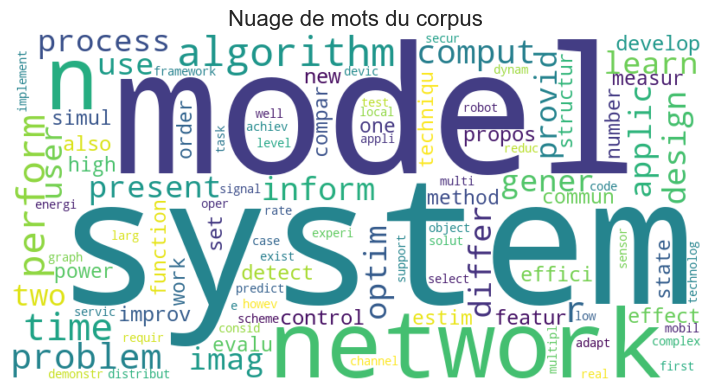

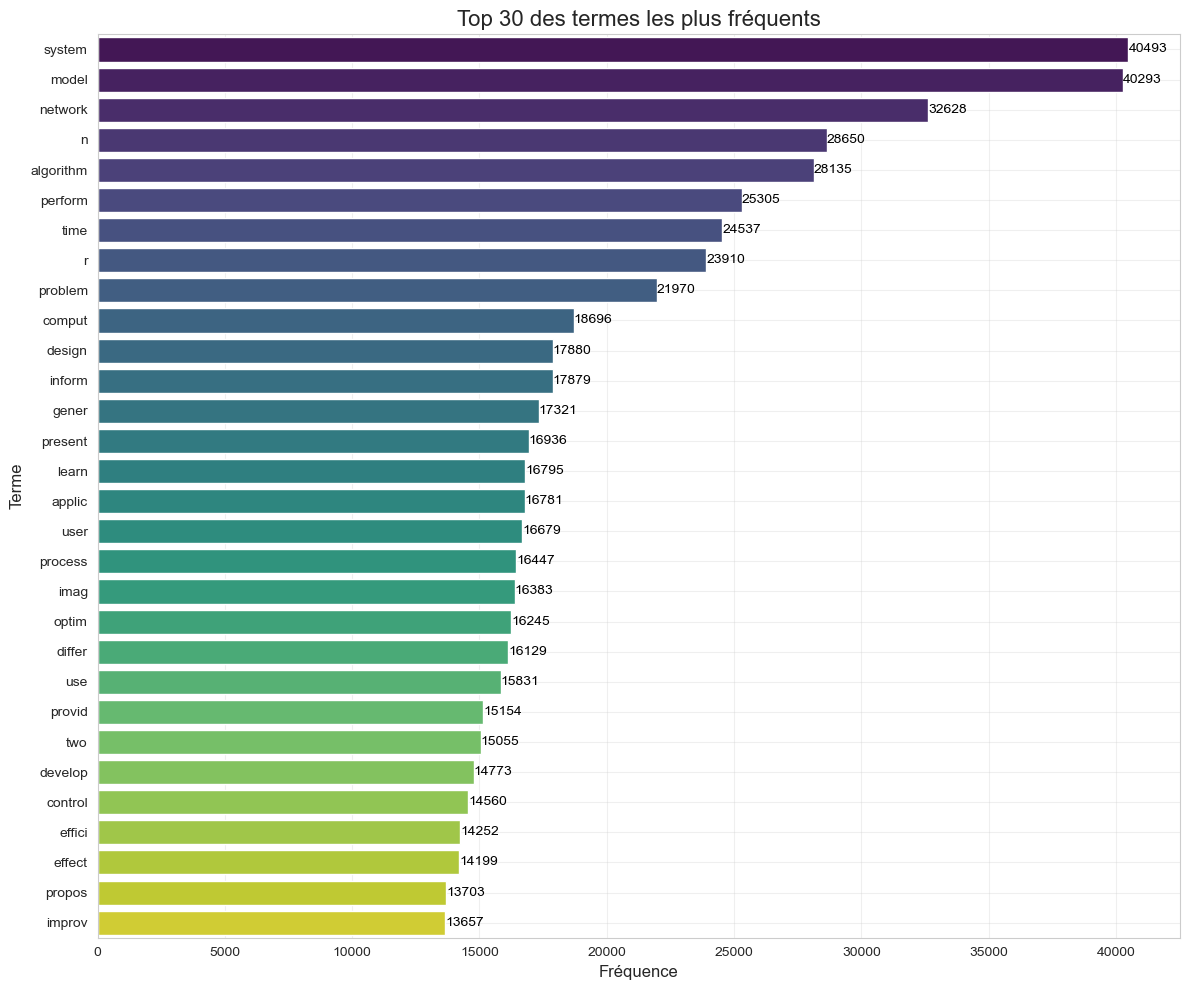

In [ ]:
# Visualisation des termes fréquents
term_viz = TermVisualizer(df)
term_counts = term_viz.extract_term_counts(min_df=5, max_df=0.95)
term_viz.create_wordcloud(max_words=100)
term_viz.plot_top_terms(n_terms=30)
interactive_hist = term_viz.create_interactive_term_histogram(n_terms=50)
interactive_hist 

## Visualisation des co-occurrences

Construction de la matrice de co-occurrences...


Calcul des co-occurrences: 100%|██████████| 79007/79007 [00:00<00:00, 127180.41it/s]


Matrice de co-occurrences construite: (56, 56)
Extraction des collocations...
Nombre de collocations extraites: 30


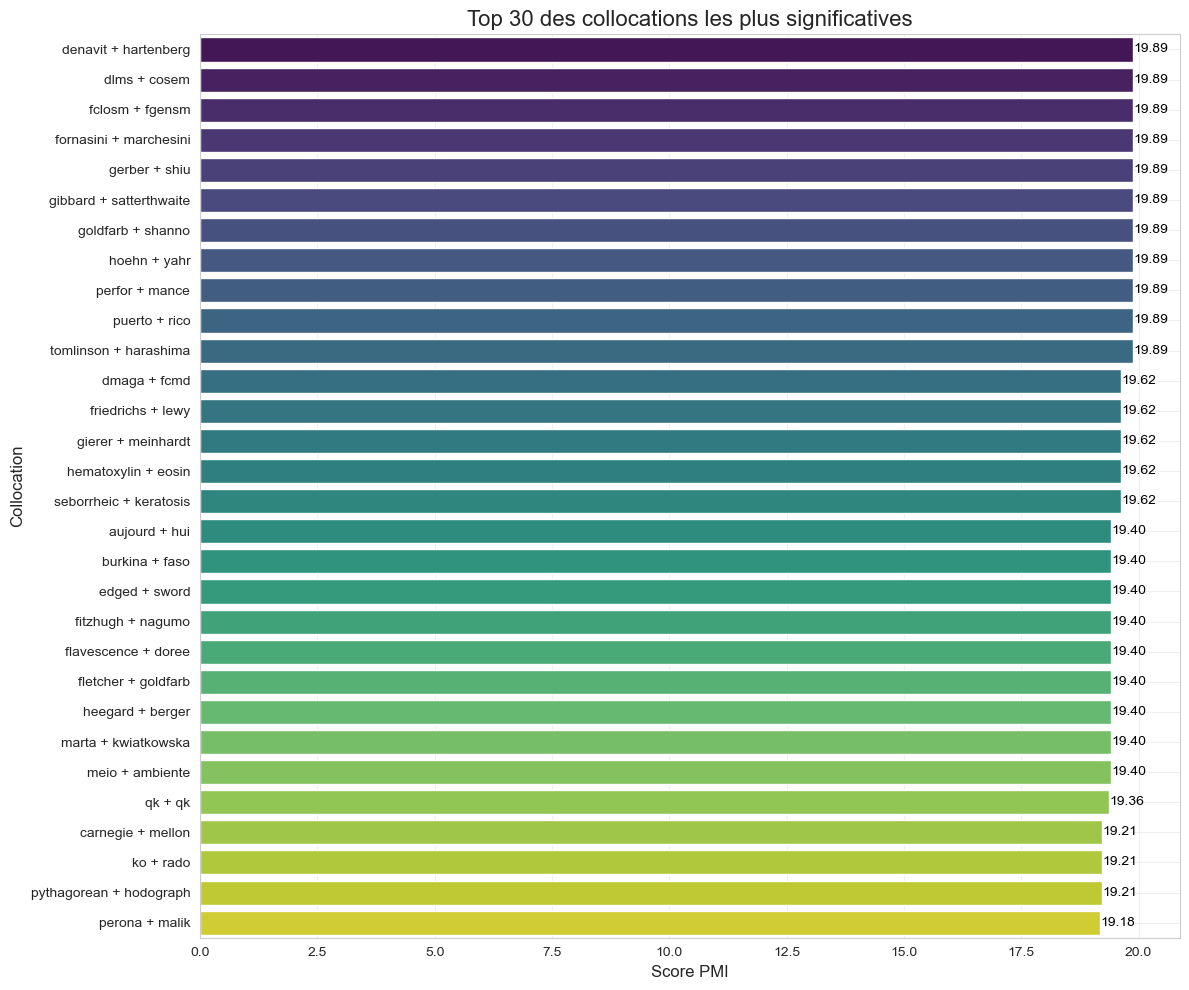

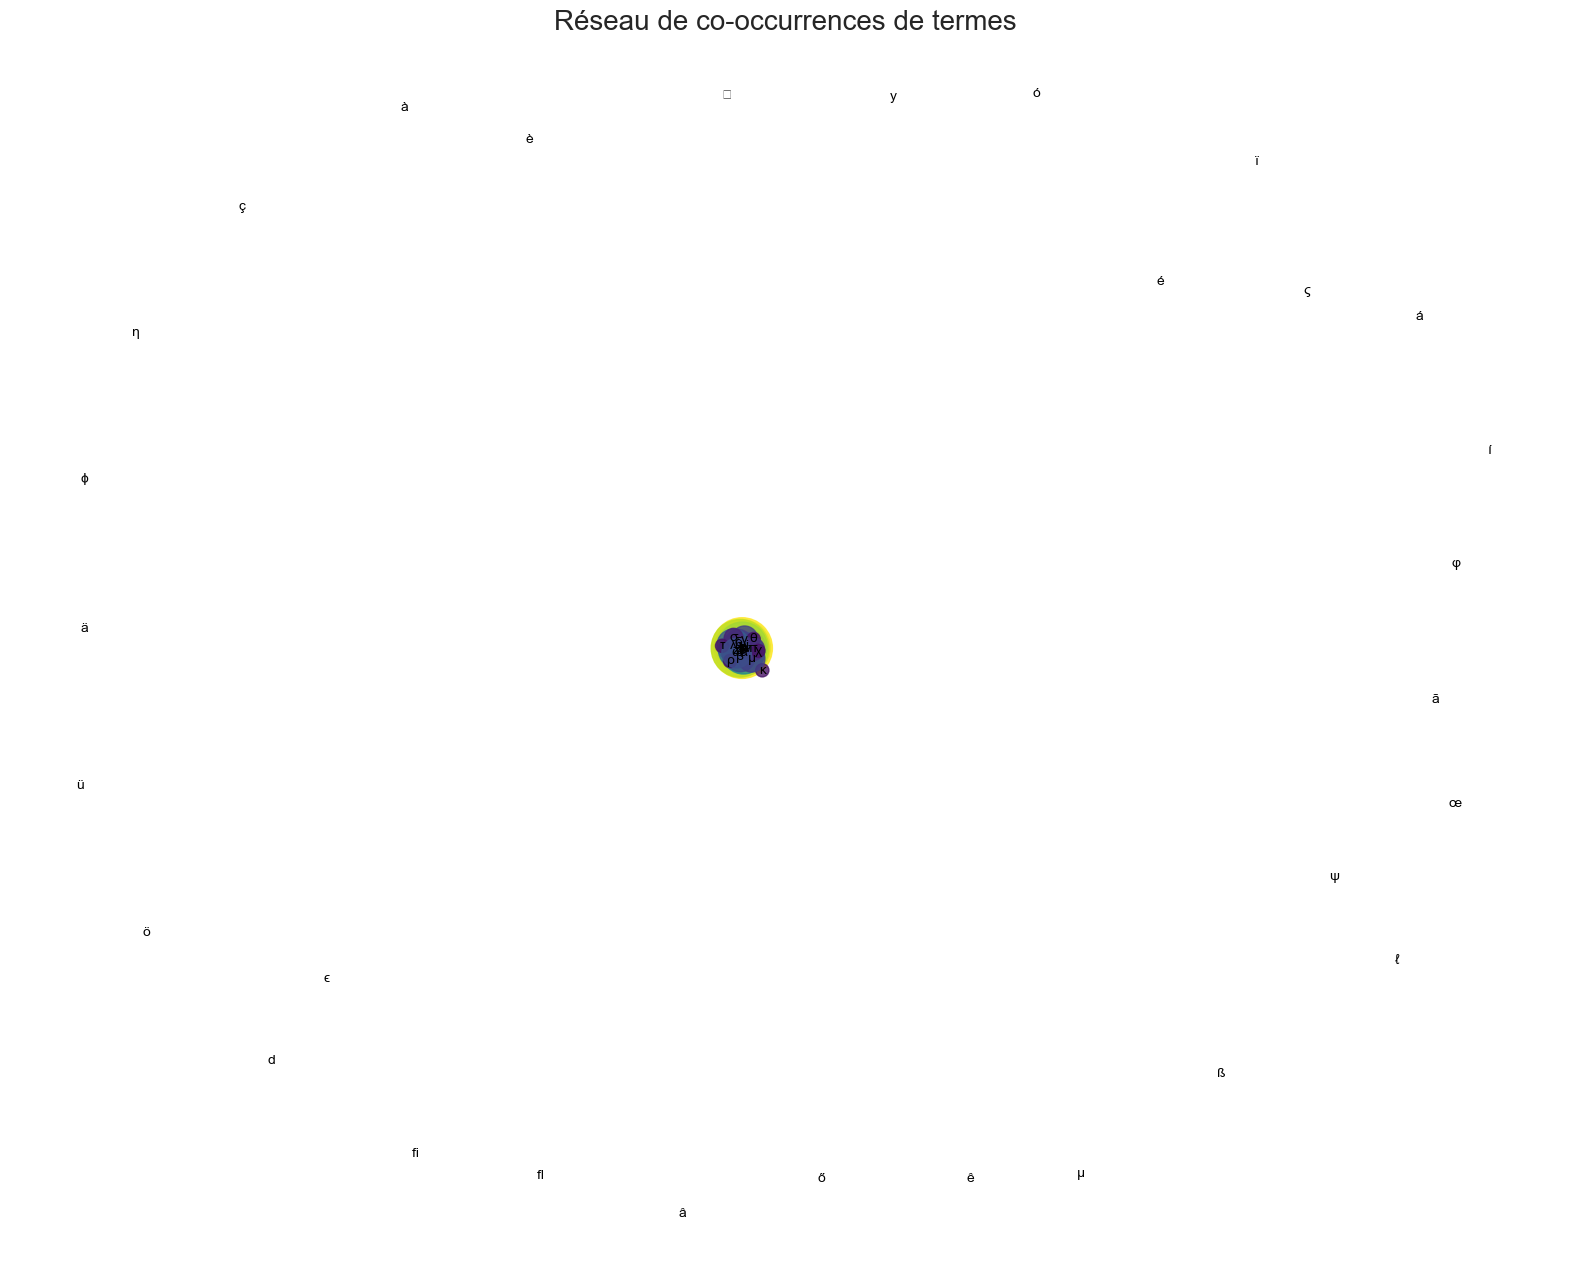

<Figure size 640x480 with 0 Axes>

In [6]:
# Visualisation des co-occurrences
cooc_viz = CooccurrenceVisualizer(df)
cooc_viz.build_cooccurrence_matrix(window_size=5, min_df=10, max_df=0.9, max_features=500)
cooc_viz.plot_collocations(n_collocations=30)
cooc_viz.plot_cooccurrence_network(n_edges=100)
cooc_network = cooc_viz.create_interactive_cooccurrence_network(n_nodes=30, n_edges=50)
cooc_network  # Pour afficher dans Jupyter


## Visualisation des thématiques LDA

Entraînement du modèle LDA...


Prétraitement des textes: 100%|██████████| 79007/79007 [00:40<00:00, 1933.71it/s]


Modèle LDA entraîné avec 10 thématiques
Thématiques extraites par le modèle LDA (10 mots par thématique):

Thématique #0:
applications (0.0119), performance (0.0099), system (0.0094), software (0.0085), memory (0.0085), mobile (0.0085), systems (0.0084), cloud (0.0083), architecture (0.0083), computing (0.0079)

Thématique #1:
system (0.0303), model (0.0253), systems (0.0213), control (0.0170), time (0.0104), design (0.0086), test (0.0082), simulation (0.0077), models (0.0075), fuzzy (0.0062)

Thématique #2:
information (0.0134), social (0.0098), user (0.0077), knowledge (0.0069), learning (0.0066), users (0.0059), use (0.0056), online (0.0053), language (0.0052), design (0.0052)

Thématique #3:
image (0.0220), images (0.0155), detection (0.0091), video (0.0085), object (0.0080), motion (0.0069), segmentation (0.0064), visual (0.0063), spatial (0.0060), resolution (0.0059)

Thématique #4:
power (0.0161), channel (0.0132), signal (0.0110), frequency (0.0092), performance (0.0089), low (

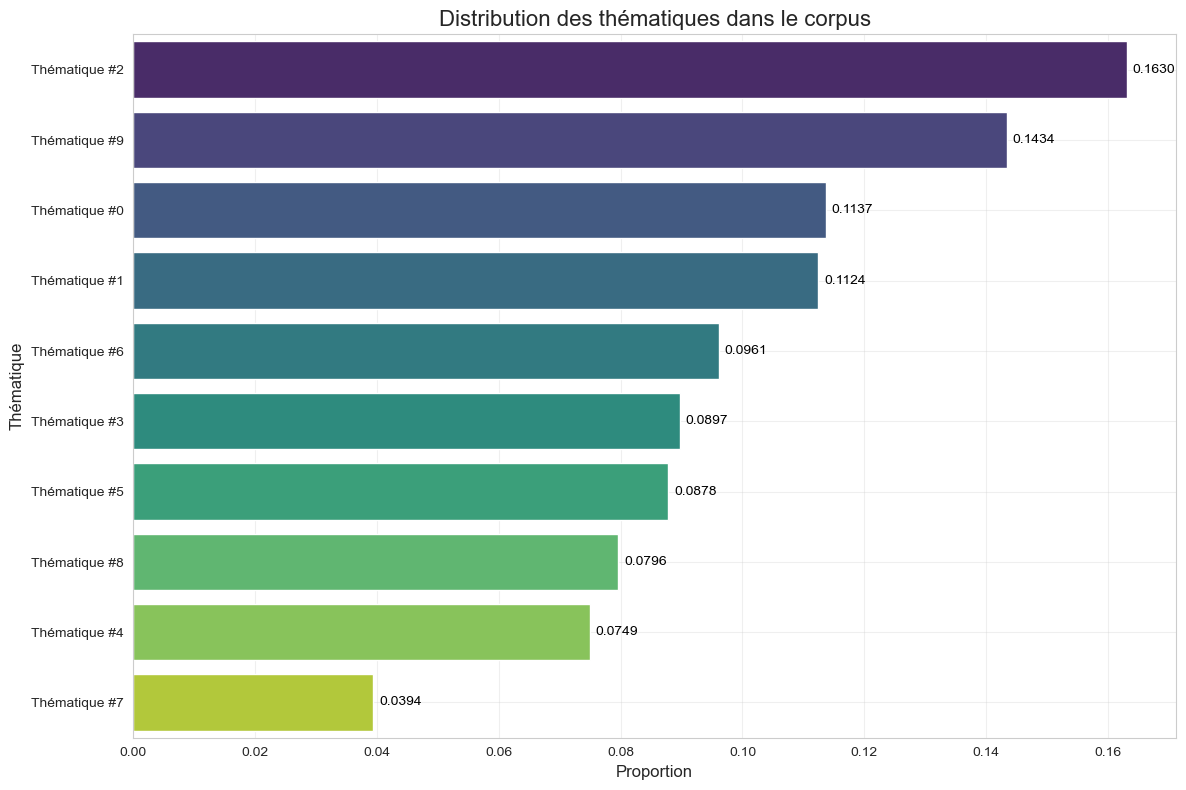

<Figure size 640x480 with 0 Axes>

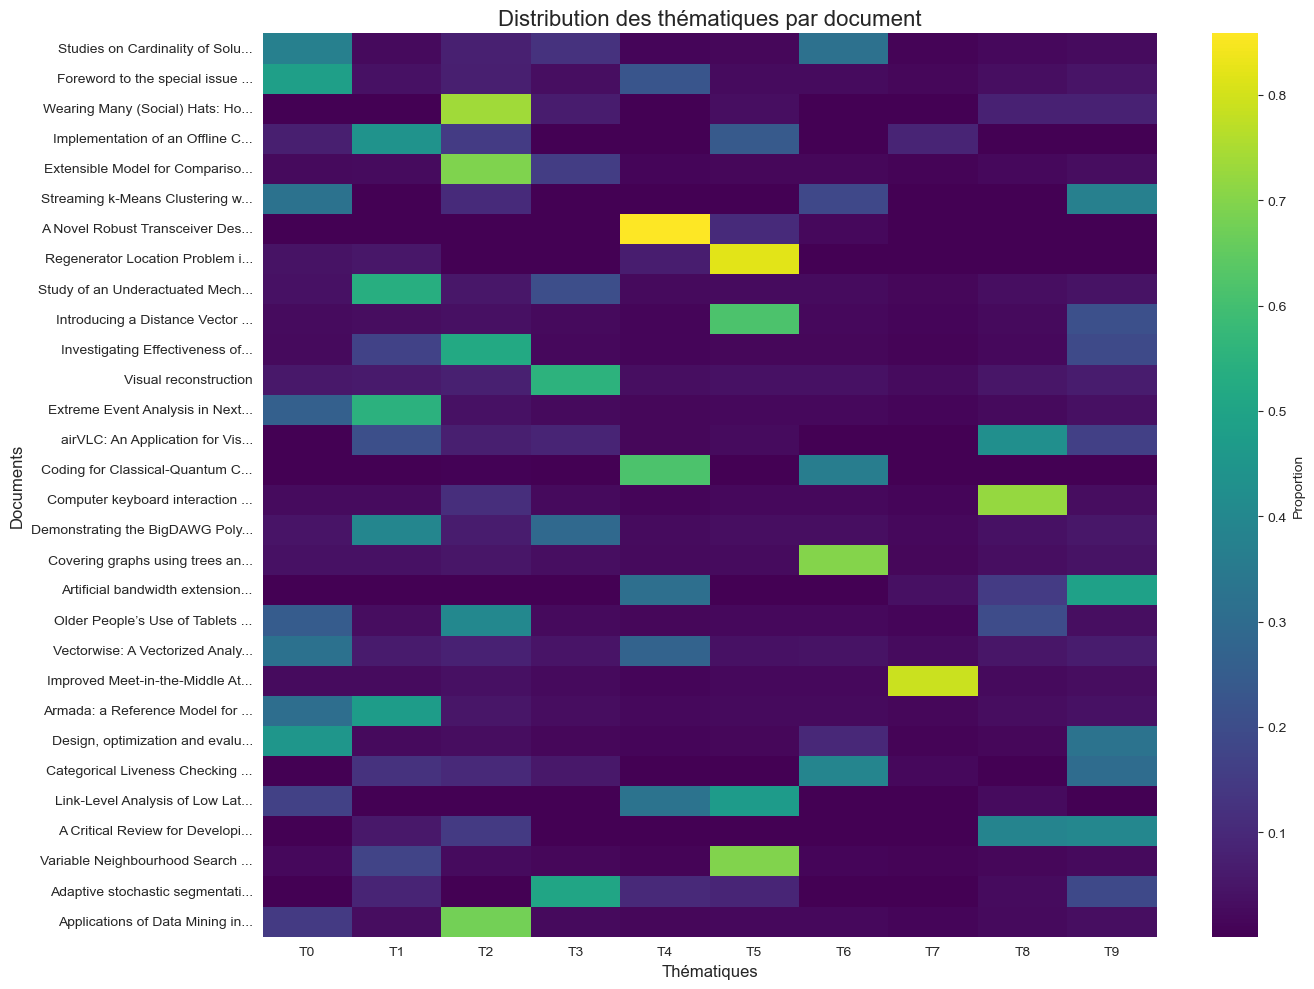

<Figure size 640x480 with 0 Axes>

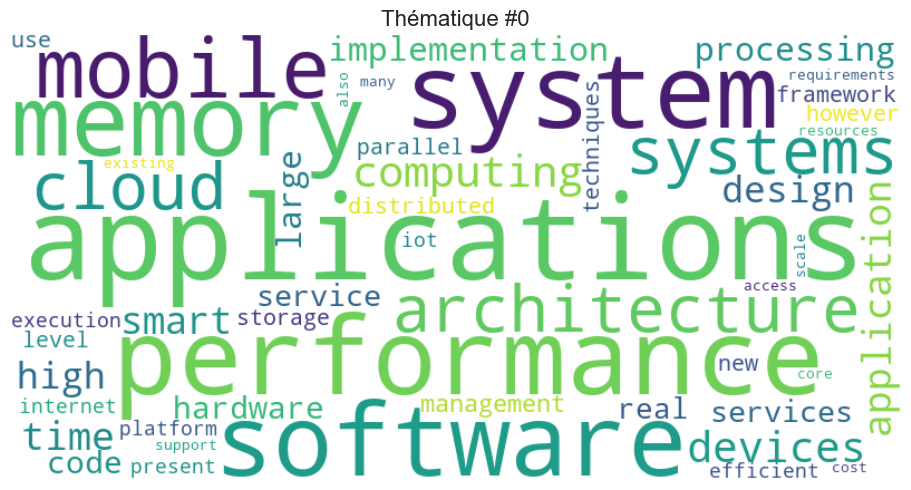

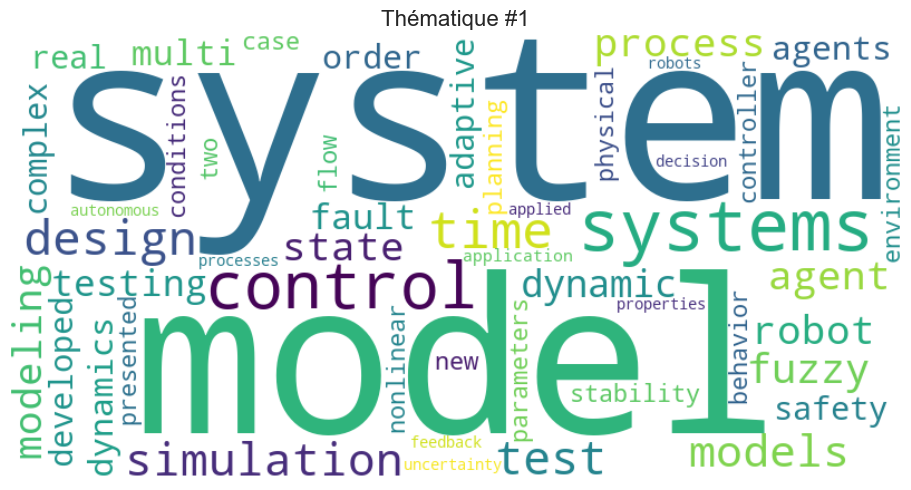

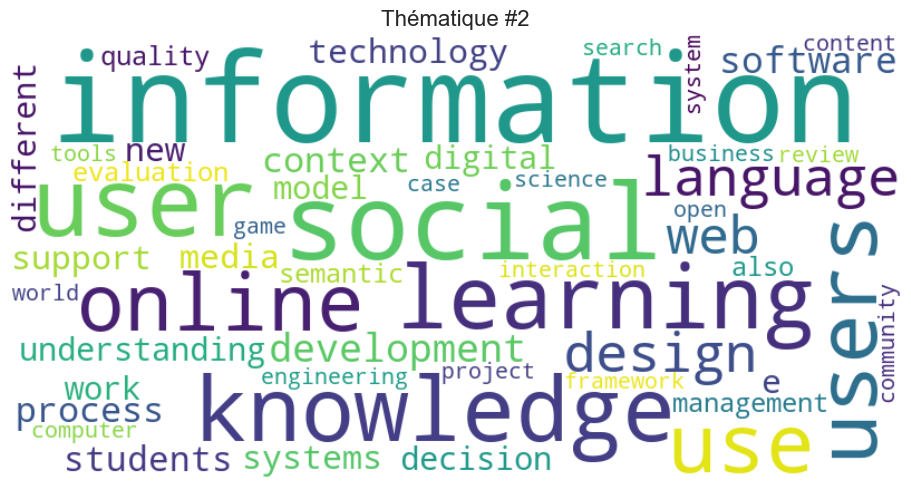

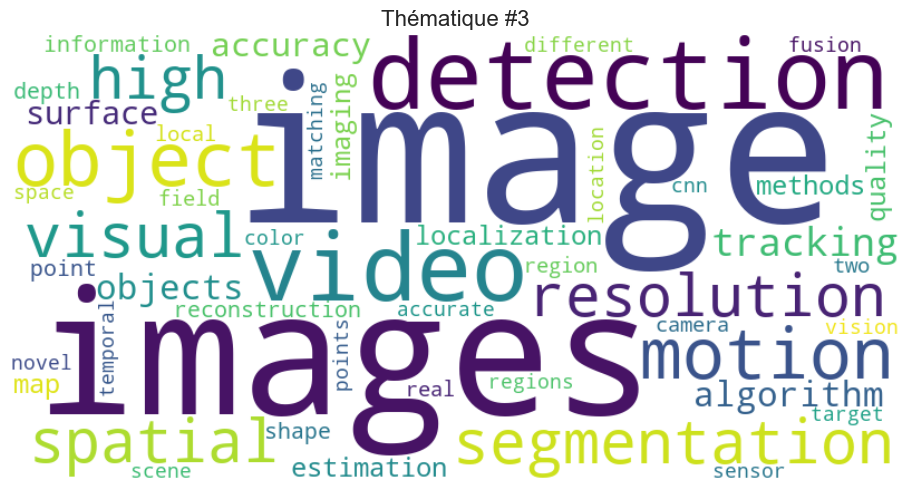

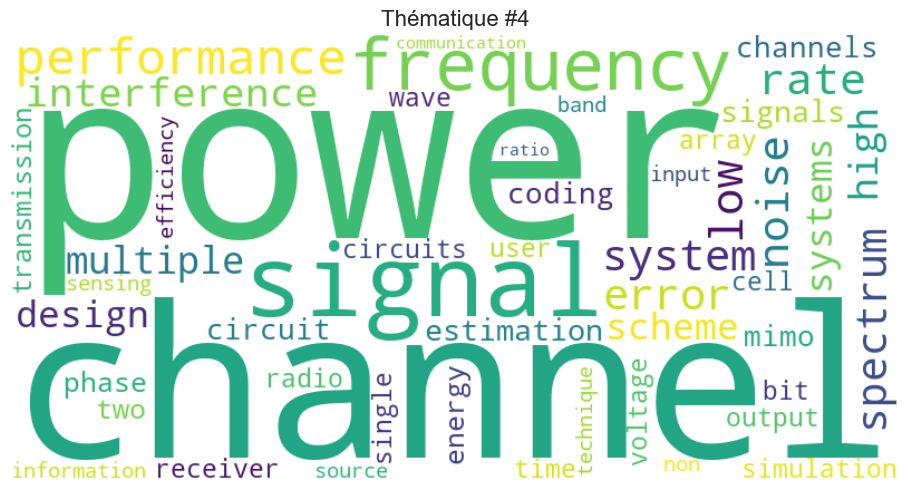

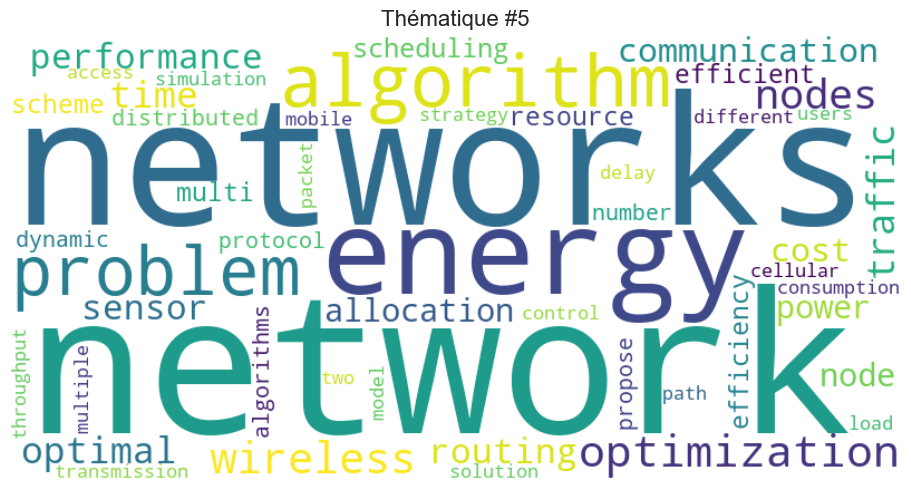

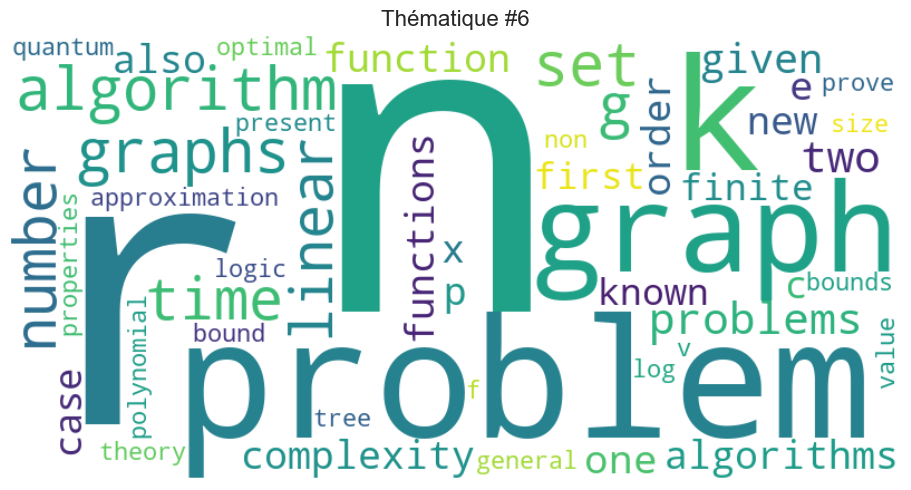

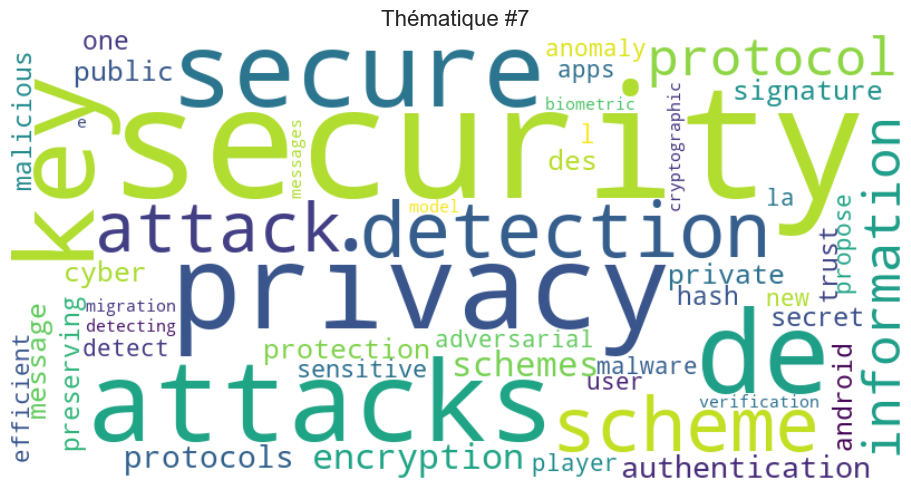

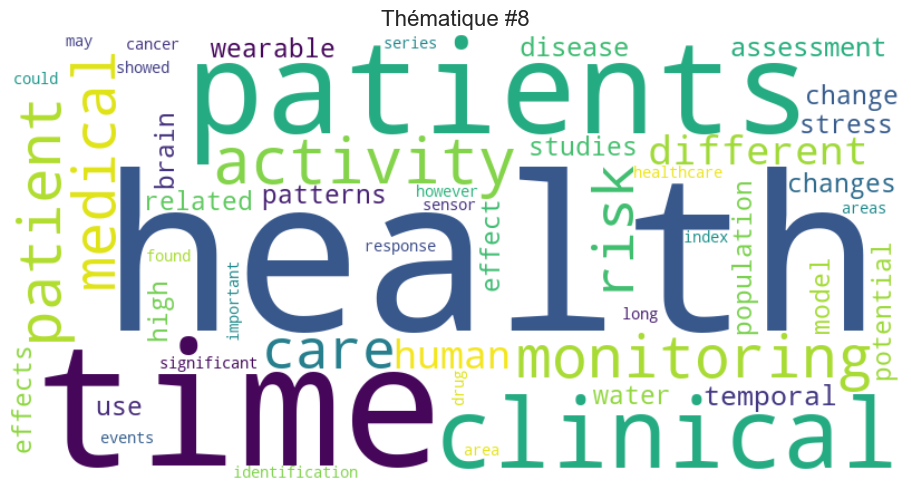

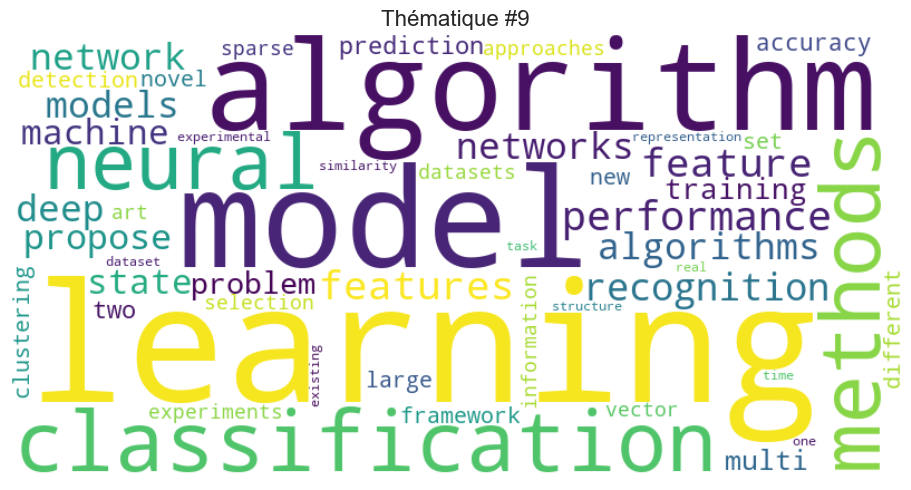

{0: <wordcloud.wordcloud.WordCloud at 0x190326b13d0>,
 1: <wordcloud.wordcloud.WordCloud at 0x19032821190>,
 2: <wordcloud.wordcloud.WordCloud at 0x1904394a750>,
 3: <wordcloud.wordcloud.WordCloud at 0x19042aaec30>,
 4: <wordcloud.wordcloud.WordCloud at 0x19042ab3b30>,
 5: <wordcloud.wordcloud.WordCloud at 0x19032b404d0>,
 6: <wordcloud.wordcloud.WordCloud at 0x19032a34620>,
 7: <wordcloud.wordcloud.WordCloud at 0x19043ddcaa0>,
 8: <wordcloud.wordcloud.WordCloud at 0x19042ab1640>,
 9: <wordcloud.wordcloud.WordCloud at 0x19042f89a30>}

In [7]:
# Visualisation des thématiques LDA
lda_viz = LDAVisualizer(df)
lda_model = lda_viz.fit_lda_model(num_topics=10, passes=10)
lda_viz.print_topics()
pyldavis_viz = lda_viz.visualize_lda_with_pyldavis()
lda_viz.plot_topic_distribution()
lda_viz.plot_document_topic_heatmap(n_docs=30)
lda_viz.create_topic_wordclouds()

## Interface interactive pour l'exploration

In [8]:
# Interface interactive pour l'exploration
# Recherche de la colonne de cluster
cluster_column = None
for col in df.columns:
    if 'cluster' in col:
        cluster_column = col
        break
        
explorer = InteractiveExplorer(
    df, 
    cluster_column=cluster_column,
    lda_model=lda_viz.lda_model,
    doc_topic_matrix=lda_viz.doc_topic_matrix
)
explorer.create_interactive_explorer()

<Figure size 640x480 with 0 Axes>